In [2]:
import torch
import torch.nn as nn
import torch.optim as optim 
from torch.utils.data.dataset import Dataset 
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from torchvision import transforms,models
import numpy as np
import matplotlib.pyplot as plt
import cv2
import time
import os
import shutil
from sklearn.metrics import f1_score   
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns


In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") # device object

In [4]:
transforms_train = transforms.Compose([
    transforms.Resize((224, 224)),   #must same as here
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(), # data augmentation
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) # normalization
])

In [5]:
transforms_val = transforms.Compose([
    transforms.Resize((224, 224)),   #must same as here
     transforms.CenterCrop((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

In [6]:
transforms_test = transforms.Compose([
    transforms.Resize((224, 224)),   #must same as here
     transforms.CenterCrop((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

In [7]:
train_dir = "Data/train/"
test_dir = "Data/test/"
val_dir= "Data/val/"
train_flooded_dir = "Data/train/flooded/"
train_non_flooded_dir = "Data/train/non-flooded/"
val_flooded_dir = "Data/val/flooded/"
val_non_flooded_dir = "Data/val/non-flooded/"
test_flooded_dir = "Data/test/flooded/"
test_non_flooded_dir = "Data/test/non-flooded/"

In [8]:
train_dataset = ImageFolder(train_dir, transforms_train)
test_dataset = ImageFolder(test_dir, transforms_test)
val_dataset = ImageFolder(val_dir, transforms_val)
train_dataloader = DataLoader(train_dataset, batch_size=12, shuffle=True, num_workers=8)
val_dataloader = DataLoader(val_dataset, batch_size=12, shuffle=True, num_workers=8)
test_dataloader = DataLoader(test_dataset, batch_size=12, shuffle=False, num_workers=8)

In [9]:
print('Train dataset size:', len(train_dataset))
print('Test dataset size:', len(test_dataset))
print('Val dataset size:', len(val_dataset))
class_names = train_dataset.classes
print('Class names:', class_names)

Train dataset size: 644
Test dataset size: 140
Val dataset size: 138
Class names: ['flooded', 'non-flooded']


In [10]:
model = models.regnet_x_1_6gf(pretrained=True)   #load regNet16 model


c:\Users\rorod\miniforge3\envs\new_python_nlp_2\lib\site-packages\torchvision\models\_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and may be removed in the future, "
c:\Users\rorod\miniforge3\envs\new_python_nlp_2\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=RegNet_X_1_6GF_Weights.IMAGENET1K_V1`. You can also use `weights=RegNet_X_1_6GF_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [11]:
num_features = model.fc.in_features     #extract fc layers features


In [12]:
model.fc = nn.Linear(num_features, 2) #(num_of_class == 2)


In [13]:
model = model.to(device) 


In [14]:
criterion = nn.CrossEntropyLoss()  #(set loss function)


In [15]:
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

In [17]:
num_epochs = 10   #(set no of epochs)
start_time = time.time() #(for showing time)

for epoch in range(num_epochs): #(loop for every epoch)
    print("Epoch {} running".format(epoch)) #(printing message)
    """ Training Phase """
    model.train()    #(training model)
    running_loss = 0.   #(set loss 0)
    running_corrects = 0 
    # load a batch data of images
    targets = []
    results = []
    for i, (inputs, labels) in enumerate(train_dataloader):
        inputs = inputs.to(device)
        labels = labels.to(device) 
        # forward inputs and get output
        optimizer.zero_grad()
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        loss = criterion(outputs, labels)
        results.append(preds)
        targets.append(labels)
        # get loss value and update the network weights
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
    results =torch.cat(results, dim=0)
    targets = torch.cat(targets, dim=0)

    results = results.to('cpu').numpy().flatten()
    targets = targets.to('cpu').numpy().flatten()

    f1_value =  f1_score(results, targets)
    epoch_loss = running_loss / len(train_dataset)
    epoch_acc = running_corrects / len(train_dataset) * 100.
    print('[Train #{}] Loss: {:.4f} Acc: {:.4f}% Time: {:.4f}s'.format(epoch, epoch_loss, epoch_acc, time.time() -start_time))
    print('F1-Score', f1_value)
    """ Val Phase """
    model.eval()
    with torch.no_grad():
        running_loss = 0.
        running_corrects = 0
        targets = []
        results = []
        for inputs, labels in val_dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            results.append(preds)
            targets.append(labels)
            loss = criterion(outputs, labels)
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)
        epoch_loss = running_loss / len(val_dataset)
        epoch_acc = running_corrects / len(val_dataset) * 100.
        results = torch.cat(results, dim=0)
        targets =torch.cat(targets, dim=0)
        results = results.to('cpu').numpy().flatten()
        targets = targets.to('cpu').numpy().flatten()
        f1_value =  f1_score(results, targets)
        print('[Val #{}] Loss: {:.4f} Acc: {:.4f}% Time: {:.4f}s'.format(epoch, epoch_loss, epoch_acc, time.time()- start_time))
        print('F1-Score', f1_value)
    model.eval()
    with torch.no_grad():
        running_loss = 0.
        running_corrects = 0
        targets = []
        results = []
        for inputs, labels in test_dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            results.append(preds)
            targets.append(labels)
            loss = criterion(outputs, labels)
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)
        epoch_loss = running_loss / len(test_dataset)
        epoch_acc = running_corrects / len(test_dataset) * 100.
        results = torch.cat(results, dim=0)
        targets =torch.cat(targets, dim=0)
        results = results.to('cpu').numpy().flatten()
        targets = targets.to('cpu').numpy().flatten()
        f1_value =  f1_score(results, targets)
        print('F1-Score', f1_value)
        print('[Test ] Loss: {:.4f} Acc: {:.4f}% Timwsee: {:.4f}s'.format( epoch_loss, epoch_acc, time.time()- start_time))
        print(classification_report(results,targets))

Epoch 0 running
[Train #0] Loss: 0.3078 Acc: 87.7329% Time: 105.2470s
F1-Score 0.8763693270735524
[Val #0] Loss: 0.1286 Acc: 95.6522% Time: 117.8443s
F1-Score 0.9565217391304348
F1-Score 0.9790209790209791
[Test ] Loss: 0.1360 Acc: 97.8571% Timwsee: 129.3527s
              precision    recall  f1-score   support

           0       0.96      1.00      0.98        67
           1       1.00      0.96      0.98        73

    accuracy                           0.98       140
   macro avg       0.98      0.98      0.98       140
weighted avg       0.98      0.98      0.98       140

Epoch 1 running
[Train #1] Loss: 0.2121 Acc: 92.3913% Time: 235.9117s
F1-Score 0.9258698940998487
[Val #1] Loss: 0.1206 Acc: 94.9275% Time: 247.8200s
F1-Score 0.9473684210526315
F1-Score 0.9710144927536232
[Test ] Loss: 0.1015 Acc: 97.1429% Timwsee: 259.3074s
              precision    recall  f1-score   support

           0       0.99      0.96      0.97        72
           1       0.96      0.99      0.97 

In [ ]:
model.eval()
with torch.no_grad():
    running_loss = 0.
    running_corrects = 0
    targets = []
    results = []
    for inputs, labels in test_dataloader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        results.append(preds)
        targets.append(labels)
        loss = criterion(outputs, labels)
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
    epoch_loss = running_loss / len(test_dataset)
    epoch_acc = running_corrects / len(test_dataset) * 100.
    results = torch.cat(results, dim=0)
    targets =torch.cat(targets, dim=0)
    results = results.to('cpu').numpy().flatten()
    targets = targets.to('cpu').numpy().flatten()
    f1_value =  f1_score(results, targets)
    print('F1-Score', f1_value)
    print('[Test ] Loss: {:.4f} Acc: {:.4f}% Timwsee: {:.4f}s'.format( epoch_loss, epoch_acc, time.time()- start_time))
    print(classification_report(results,targets))

F1-Score 0.9855072463768115
[Test ] Loss: 0.0612 Acc: 98.5714% Timwsee: 1980.4562s
              precision    recall  f1-score   support

           0       1.00      0.97      0.99        72
           1       0.97      1.00      0.99        68

    accuracy                           0.99       140
   macro avg       0.99      0.99      0.99       140
weighted avg       0.99      0.99      0.99       140



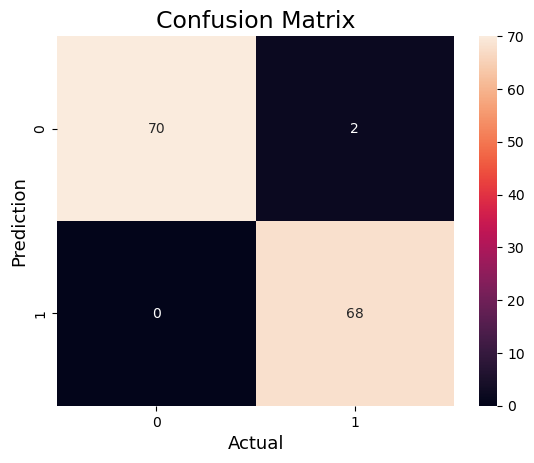

In [ ]:

# Compute the confusion matrix.
cm = confusion_matrix(results,targets)
# Plot the confusion matrix.
# Plot the confusion matrix.
new_labels = list(set(targets))
new_labels.sort()
sns.heatmap(cm, annot=True, fmt='g', xticklabels=new_labels, yticklabels=new_labels)
plt.ylabel('Prediction',fontsize=13)
plt.xlabel('Actual',fontsize=13)
plt.title('Confusion Matrix',fontsize=17)
plt.show()

In [18]:
torch.save(model.state_dict(), "regnet2.pt")

In [20]:
model2 =models.regnet_x_1_6gf()
num_features = model2.fc.in_features   
model2.fc = nn.Linear(num_features, 2) 
model2.load_state_dict(torch.load("regnet2.pt"))

<All keys matched successfully>